In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


In [3]:
import os
import pandas as pd
BASE_PATH = r"dataset augm"
image = []
labels = []

backgroundImages = []
laneImages = []
for file in os.listdir(BASE_PATH):
    if file == "background":
        for elem in os.listdir(os.path.join(BASE_PATH, file)):
            image.append(elem)
            labels.append(file)
            backgroundImages.append(elem)
    else:
        for elem in os.listdir(os.path.join(BASE_PATH, file)):
            image.append(elem)
            laneImages.append(elem)
            labels.append(file)

backgroundData = {'Images': backgroundImages,
                  'labels': ['background' for i in range(len(backgroundImages))],
                  'encoded_labels':[0 for i in range(len(backgroundImages))]}
laneData = {'Images': laneImages,
            'labels': ['lane' for i in range(len(laneImages))],
            'encoded_labels':[1 for i in range(len(laneImages))]}

backgroundData = pd.DataFrame(backgroundData)
laneData = pd.DataFrame(laneData)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)
data.head()


,Images,labels
0,1.jpg,background
1,10.jpg,background
2,100.jpg,background
3,1000.jpg,background
4,10000.jpg,background


In [4]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()


,Images,labels,encoded_labels
0,1.jpg,background,0
1,10.jpg,background,0
2,100.jpg,background,0
3,1000.jpg,background,0
4,10000.jpg,background,0


In [13]:
import numpy as np
batch_size = 32
validation_split = .3
shuffle_dataset = True
random_seed = 42

# Creating data indices for training and validation splits:
# from sklearn.model_selection import train_test_split
# tr, val = train_test_split(data.label, stratify=data.label, test_size=0.1)
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# train_indices is equivalent to list(tr.index)
# val_indices is equivalent to list(val.index)


backgroundImagesSplit = int(np.floor(validation_split * len(backgroundData)))
laneImagesSplit = int(np.floor(validation_split * len(laneData)))

TRAIN_DATA = pd.concat(
    [backgroundData[backgroundImagesSplit:], laneData[laneImagesSplit:]],ignore_index=True) 
VALIDATION_DATA = pd.concat(
    [backgroundData[:backgroundImagesSplit], laneData[:laneImagesSplit]],ignore_index=True)


In [14]:
from torch.utils.data.sampler import SubsetRandomSampler
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.ColorJitter(contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
    # transforms.RandomRotation(degrees=15), 
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [16]:
from torch.utils.data import Dataset, DataLoader
class LaneDataset(Dataset):
    def __init__(self,img_data,img_path,transform=None) -> None:
        super().__init__()
        self.img_data=img_data
        self.img_path=img_path
        self.transform=transform

    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name=os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
        self.img_data.loc[index,'Images'])
        image=Image.open(img_name)
        if self.transform is not None:
            image=self.transform(image)
        label=torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return image, label
        
        
        



In [17]:
import torch.nn as nn
import torch.nn.functional as F

class LaneClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1=nn.Conv2d(3,10,3)
        self.pool1=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(10,6,3)
        self.conv3=nn.Conv2d(6,4,3)
        self.fc1=nn.Linear(4*3*27,256)
        self.fc2=nn.Linear(256,32)
        self.fc3=nn.Linear(32,2)
    
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=F.relu(self.conv2(x))
        x=F.relu(self.conv3(x))
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.softmax(self.fc3(x),dim=1)
        return x
laneClassifier= LaneClassifier().to(device)
print(laneClassifier)

LaneClassifier(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=324, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
dataset=LaneDataset(data, BASE_PATH,transform)

validationDataset=LaneDataset(VALIDATION_DATA,BASE_PATH,transform)
trainDataset=LaneDataset(TRAIN_DATA,BASE_PATH,transform)

In [19]:
train_loader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
valdiation_loader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,sampler=valid_sampler)

# train_loader=torch.utils.data.DataLoader(trainDataset,batch_size=batch_size)
# valdiation_loader=torch.utils.data.DataLoader(validationDataset,batch_size=batch_size)
print(TRAIN_DATA)
print(VALIDATION_DATA)

          Images      labels  encoded_labels
0      14082.jpg  background               0
1      14083.jpg  background               0
2      14084.jpg  background               0
3      14085.jpg  background               0
4      14086.jpg  background               0
...          ...         ...             ...
14555    v84.jpg        lane               1
14556    v89.jpg        lane               1
14557     v9.jpg        lane               1
14558    v92.jpg        lane               1
14559    v97.jpg        lane               1

[14560 rows x 3 columns]
                  Images      labels  encoded_labels
0                  1.jpg  background               0
1                 10.jpg  background               0
2                100.jpg  background               0
3               1000.jpg  background               0
4              10000.jpg  background               0
...                  ...         ...             ...
6235  h1672778661240.png        lane               1
6236  h167

In [20]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

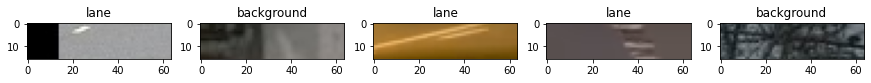

In [21]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
arthopod_types = {0: 'background', 1: 'lane'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(laneClassifier.parameters(), lr=0.5*10**-4  )

In [23]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [24]:
n_epochs = 100
print_every = 80
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = laneClassifier(data_)
        target_=target_.long()
        loss = criterion(outputs,target_)
        
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)

        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        laneClassifier.eval()
        for data_t, target_t in (valdiation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = laneClassifier(data_t)
            target_t=target_t.long()
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            pred_t = torch.argmax(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(valdiation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight
        if epoch == 10:
             torch.save(laneClassifier.state_dict(), 'model_classification_tutorial_10.pt')
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(laneClassifier.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    laneClassifier.train()

Epoch 1

Epoch [1/100], Step [0/455], Loss: 0.7042
Epoch [1/100], Step [80/455], Loss: 0.6777
Epoch [1/100], Step [160/455], Loss: 0.6919


KeyboardInterrupt: 

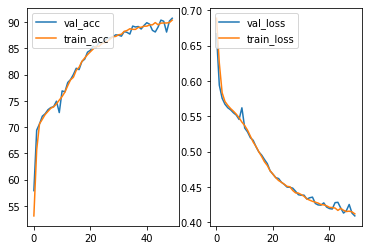

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(val_acc, label="val_acc")
plt.plot(train_acc, label="train_acc")
plt.legend(loc="upper left")
plt.subplot(1, 2, 2)
plt .plot(val_loss, label="val_loss")
plt .plot(train_loss, label="train_loss")
plt.legend(loc="upper left")